In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from bbox_plotter import yolo_to_corners
from torchvision.ops import complete_box_iou_loss
from torchvision.models import densenet121
from PIL import Image
import numpy as np
import csv
import os
import cv2
from bbox_plotter import visualize_prediction
from loss_curve_visualization import plot_training_history
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
class ZebrafishDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

class ZebrafishValDataset(Dataset):
    def __init__(self, image_folder, label_subfolder, transform=None):
        self.image_folder = image_folder
        self.label_folder = os.path.join(image_folder, label_subfolder) 
        self.image_files = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image) 

        label_filename = os.path.splitext(self.image_files[idx])[0] + '.txt'
        label_path = os.path.join(self.label_folder, label_filename)
        label = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    label.append([x, y, w, h])

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32).squeeze(0)

In [3]:
images_path = "D:\Praharsha\code\CAMZ\data\interim\X_labelled_data.npy"
labels_path = "D:\Praharsha\Code\CAMZ\data\interim\y_labelled_data.npy"
val_images_path = r"D:\Praharsha\code\CAMZ\data\raw\validation_data"
val_labels_path = r"D:\Praharsha\code\CAMZ\data\raw\validation_labels"
transform = transforms.ToTensor()
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = ZebrafishDataset(images_path, labels_path, transform=transform)
val_dataset = ZebrafishValDataset(val_images_path, val_labels_path, transform=transform_val)

In [4]:
train_loader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size=32, shuffle=True)

In [5]:
DenseNet121 = densenet121(pretrained = False)
DenseNet121.classifier = nn.Linear(1024,4)

In [6]:
class CompleteBoxLoss(nn.Module):
    def __init__(self):
        super(CompleteBoxLoss, self).__init__()

    def forward(self, pred_boxes, true_boxes, reduction):
        ciou = complete_box_iou_loss(pred_boxes, true_boxes, reduction)
        
        return ciou


In [7]:
model = DenseNet121.to('cuda')
ciou_loss_function = CompleteBoxLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
def Initialize_writer(file_path,columns = ['epoch','loss','val_loss']):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, mode='w', newline="") as file:
        writer = csv.writer(file)
        writer.writerow(columns)

In [10]:
def validate(model, val_loader, loss_function, epoch):
    model.eval()
    ciou_total_batch_loss = 0.0
    ciou_loss_per_batch_val_history = []
    batch_num = 1
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = yolo_to_corners(model(inputs), image_width=224, image_height=224)
            norm_labels = yolo_to_corners(labels, image_width=224, image_height=224)
            
            ciou_loss_per_batch = loss_function(outputs, norm_labels, 'mean')
            ciou_loss_per_batch_val_history.append([epoch+1, batch_num, ciou_loss_per_batch.item()])
            ciou_total_batch_loss += ciou_loss_per_batch.item()
            batch_num += 1
        
    ciou_total_loss = ciou_total_batch_loss / len(val_loader)
    print(f"Validation for Epoch [{epoch+1}], CIoU: {ciou_total_loss:.4f}")
    return ciou_total_loss, ciou_loss_per_batch_val_history

In [11]:
def train(model, train_loader, val_loader, optimizer, loss_function,
          epoch_history_csv_path, batch_train_history_csv_path, batch_val_history_csv_path, 
          save_model_checkpoint_path, num_epochs=1, patience=20, delta=0.001):
    
    Initialize_writer(epoch_history_csv_path)
    Initialize_writer(batch_train_history_csv_path, columns=['epoch', 'batch', 'loss'])
    Initialize_writer(batch_val_history_csv_path, columns=['epoch', 'batch', 'loss'])
    
    best_val_ciou_loss = float('inf')
    early_stopping = 0
    
    model.train()
    
    for epoch in range(num_epochs):
        ciou_total_batch_loss = 0.0
        ciou_loss_per_batch_train_history = []
        batch_num = 1
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
            optimizer.zero_grad()
            norm_labels = yolo_to_corners(labels, image_width=224, image_height=224)
            outputs = yolo_to_corners(model(inputs), image_width=224, image_height=224)
            
            ciou_loss_per_batch = loss_function(outputs, norm_labels, 'mean')
            ciou_loss_per_batch.backward()
            optimizer.step()
            
            ciou_loss_per_batch_train_history.append([epoch+1, batch_num, ciou_loss_per_batch.item()])
            ciou_total_batch_loss += ciou_loss_per_batch.item()
            batch_num += 1
        
        ciou_loss_per_epoch = ciou_total_batch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], CIoU: {ciou_loss_per_epoch:.4f}", end=" --- ")
        
        val_ciou_loss, ciou_loss_per_batch_val_history = validate(model, val_loader, loss_function, epoch)
        
        if (best_val_ciou_loss - val_ciou_loss) > delta:
            best_val_ciou_loss = val_ciou_loss
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint, save_model_checkpoint_path)
            print(f"\n=========Saving Checkpoint======= at Epoch:[{epoch+1}/{num_epochs}]")
            early_stopping = 0
        else:
            early_stopping += 1
        
        with open(epoch_history_csv_path, mode='a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerow([epoch+1, ciou_loss_per_epoch, val_ciou_loss])
        
        with open(batch_train_history_csv_path, 'a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerows(ciou_loss_per_batch_train_history)
        
        with open(batch_val_history_csv_path, 'a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerows(ciou_loss_per_batch_val_history)
        
        if early_stopping >= patience:
            print(f"Early stopping occurred at {epoch+1}")
            break
    
    print(f"The best Validation Loss is: {best_val_ciou_loss}")

In [14]:
epoch_history_csv_file = r"D:\Praharsha\code\CAMZ\models\model_history\3.0-DenseNet121\loss_logger_epoch_wise.csv"
batch_histroy_csv_file = r"D:\Praharsha\code\CAMZ\models\model_history\3.0-DenseNet121\loss_logger_batch_wise.csv"
batch_val_history_csv_file = r"D:\Praharsha\code\CAMZ\models\model_history\3.0-DenseNet121\loss_logger_val_batch_wise.csv"
checkpoints_file = r'D:\Praharsha\code\CAMZ\models\model_history\3.0-DenseNet121\checkpoint.pth.tar'

In [15]:
train(model, train_loader, val_loader=val_loader,
      optimizer=optimizer, loss_function=ciou_loss_function, 
      batch_train_history_csv_path=batch_histroy_csv_file, 
      batch_val_history_csv_path=batch_val_history_csv_file, 
      epoch_history_csv_path=epoch_history_csv_file,
      save_model_checkpoint_path=checkpoints_file, num_epochs=200)

Epoch [1/200], CIoU: 1.3261 --- Validation for Epoch [1], CIoU: 1.2831

=========Saving Checkpoint======= at Epoch:[1/200]
Epoch [2/200], CIoU: 1.2948 --- Validation for Epoch [2], CIoU: 1.2510

=========Saving Checkpoint======= at Epoch:[2/200]
Epoch [3/200], CIoU: 1.2213 --- Validation for Epoch [3], CIoU: 1.2028

=========Saving Checkpoint======= at Epoch:[3/200]
Epoch [4/200], CIoU: 1.2362 --- Validation for Epoch [4], CIoU: 1.2571
Epoch [5/200], CIoU: 1.2371 --- Validation for Epoch [5], CIoU: 1.1868

=========Saving Checkpoint======= at Epoch:[5/200]
Epoch [6/200], CIoU: 1.2755 --- Validation for Epoch [6], CIoU: 1.2186
Epoch [7/200], CIoU: 1.2516 --- Validation for Epoch [7], CIoU: 1.2398
Epoch [8/200], CIoU: 1.2336 --- Validation for Epoch [8], CIoU: 1.2062
Epoch [9/200], CIoU: 1.2831 --- Validation for Epoch [9], CIoU: 1.5075
Epoch [10/200], CIoU: 1.3023 --- Validation for Epoch [10], CIoU: 1.2315
Epoch [11/200], CIoU: 1.2134 --- Validation for Epoch [11], CIoU: 1.1924
Epoch [

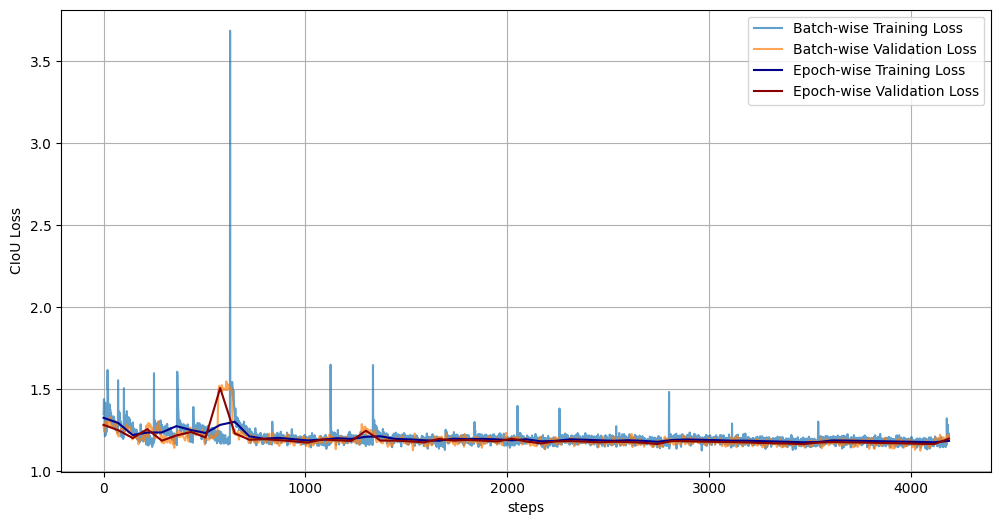

In [16]:
plot_training_history(batch_histroy_csv_file, batch_val_history_csv_file, epoch_history_csv_file)

In [ ]:
def load_checkpoint(checkpoint, architecture, optimizer):
    print("loading checkpoint...")
    checkpoint = torch.load(checkpoint)
    
    model = architecture()
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    return model.eval()
model = load_checkpoint(r"D:\Praharsha\code\CAMZ\models\model_history\3.0-DenseNet121\checkpoint.pth.tar", DenseNet121, optimizer)

loading checkpoint...


C:\Users\USER\AppData\Local\Temp\ipykernel_40464\1811305296.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint)


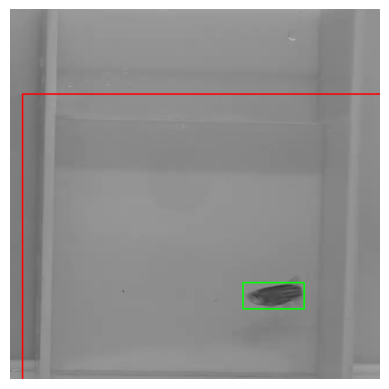

In [19]:
image_path1 = r"D:\Praharsha\code\CAMZ\data\raw\validation_data\1Rcrop1239.jpg.jpg"
image_path2 = r"D:\Praharsha\code\CAMZ\data\raw\validation_data\1Lcrop1853.jpg.jpg"
image_path3 = r"D:\Praharsha\code\CAMZ\data\raw\validation_data\4Rcrop2045.jpg.jpg"

visualize_prediction(image_path1, labels_path=r"D:\Praharsha\code\CAMZ\data\raw\validation_labels",
                     model=model)
    

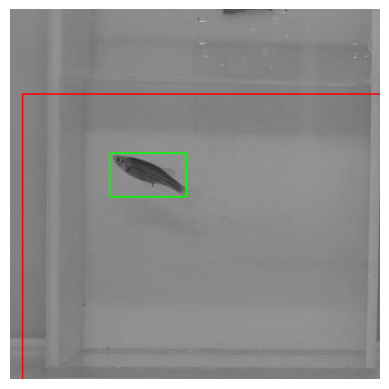

In [20]:
visualize_prediction(image_path2, labels_path=r"D:\Praharsha\code\CAMZ\data\raw\validation_labels",
                     model=model)

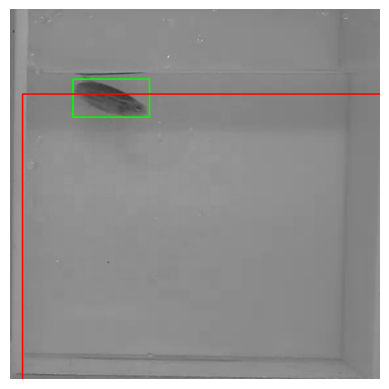

In [21]:
visualize_prediction(image_path3, labels_path=r"D:\Praharsha\code\CAMZ\data\raw\validation_labels",
                     model=model)